In [30]:
import os
import random
import shutil, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pylab as pl
from matplotlib.pyplot import figure
from collections import Counter

from os import listdir
from os.path import isfile, join

In [31]:
truth_file = pd.read_csv('/Users/sleung2/Documents/MIDS Program/Capstone_local/snapshot_wisconsin/all/yolo_splits3/test/test_labels.csv')
truth_file = truth_file.rename(columns = {'TRIGGER_ID': 'event_id',
                                               'CLASS_SPECIES': 'true_class',
                                               'Total': 'true_count',
                                               'CLASS_SPECIES_RESTATED': 'true_class_name'})

truth_file_no_other = truth_file[truth_file['true_class_name'] != 'other']

In [32]:
labels = pd.DataFrame(['foxgray_foxred',
              'cottontail_snowshoehare',
              'raccoon',
              'opossum',
              'turkey',
              'bear',
              'elk',
              'deer',
              'coyote',
              'wolf']).sort_values(0)
labels = labels.rename(columns = {0: 'species'})
labels.insert(0, 'class', range(0, len(labels)))

# Phase 2- Species

## Yolo

In [33]:
#Read lines from txt results file

toppath = 'phase 2-species/'
txt_file = 'output_indrani.txt'#'output_yolo_species_splits4.txt'

with open(toppath + txt_file, 'r') as f:
    original_lines = f.readlines()

In [34]:
#Txt file to dataframe
#We are taking the TOP confidence score species for each image as the species
#Count is the count for all bounding boxes drawn in image

rows = []

for item in original_lines:
    
    #Class number
    item_split_1 = item.split(' Bbox[list]')[0]
    class_conf_list = item_split_1.split(';')[1:-2]
    
    conf_score_max = 0
    
    i = 0    
    for class_conf in class_conf_list:
        conf_score_int = float(class_conf.split(',Conf:')[1])
        
        
        if conf_score_int > conf_score_max:
            conf_score_max = conf_score_int
            max_index = i
            
        i += 1
    try:
        class_string = class_conf_list[max_index].split(',')[0]
        class_num = float(class_string.split(':')[1])
        class_num = int(class_num)
    except:
        class_num = 'Blank'

    #Counts
    count_split_1 = item.split(' Bbox[list]')[-1]
    count_split_2 = count_split_1.replace(';', ',')  
    count_split_3 = count_split_2.split(',')
    count = int((len(count_split_3)-1)/4)
        
    #Filename
    file_split_1 = item.split('Filename: ')[1]
    file_name = file_split_1.split(';')[0].split('.jpg')[0]
        
    row = [file_name, class_num, count, conf_score_max]
    
    rows.append(row)       

predictions = pd.DataFrame(rows, columns = ['filename', 'class', 'count', 'conf_score_max'])

Species
1. Events with multiple images of same class will be labeled the majority class
- For event to be labeled Blank, all images must be blank
2. Events with all different labels will get labelled with highest confidence score 

Counts
1. Events with multiple images of same class- we will take the max of the majority class
2. Events with all different labels will get labelled with the count of highest conf score label


In [37]:
#Event column- remove A,B,C appendix
predictions['event_id'] = predictions['filename'].str[:-1]


## Events with muliple images of same class
#Species determination
#Groupby event, class
event_class_group_count = pd.DataFrame(predictions.groupby(['event_id', 'class']).count()['filename']).reset_index().rename(columns = {'filename': 'count_rows'})

#Filter by rows that have count greater than 1
event_class_group_count_majority = event_class_group_count[event_class_group_count['count_rows'] > 1]

#Remove blank events that are not a consensus for all 3 images
event_class_group_count_majority = event_class_group_count_majority[~((event_class_group_count_majority['class'] == 'Blank') &
                                (event_class_group_count_majority['count_rows'] < 3))]

#Count determination
event_class_group_majority_counts = pd.merge(predictions, event_class_group_count_majority,
         how = 'inner',
         on = ['event_id', 'class'])

event_class_majority_counts = event_class_group_majority_counts[['event_id', 'count']].groupby(['event_id']).max().reset_index()

event_max_conf_score = event_class_group_majority_counts[['event_id', 'conf_score_max']].groupby(['event_id']).max().reset_index()

majority_df = pd.merge(event_class_majority_counts, event_class_group_count_majority,
         on = 'event_id',
         how = 'left')[['event_id', 'count','class']]

majority_df = pd.merge(majority_df, event_max_conf_score,
         on = 'event_id',
         how = 'left')

## Events with all different labels
predictions_single_count = predictions[~predictions['event_id'].isin(majority_df['event_id'])]

event_list = []
pred_list = []
count_list = []
conf_score_max_list = []

previous_event = ''
conf_score_group_max = 0
pred_class = ''
conf_score_group_max = 0

predictions_single_count_grouped = predictions_single_count.groupby(['event_id', 'class',
                                                                     'conf_score_max'])

for group_name, group in predictions_single_count_grouped:
        
    current_event = group_name[0]
    current_class = group['class'].iloc[0]
    current_conf_score = group['conf_score_max'].iloc[0]
    current_count = group['count'].iloc[0]
    
    #Check if we are looking at a new event
    if current_event != previous_event:
        conf_score_max_list.append(conf_score_group_max)
        conf_score_group_max = 0
        event_list.append(previous_event)
        pred_list.append(pred_class)
        count_list.append(current_count)
        
    if conf_score_group_max < current_conf_score:
        pred_class = current_class
        conf_score_group_max = current_conf_score
        
    previous_event = current_event 

conf_score_max_list.append(conf_score_group_max)
event_list.append(previous_event)
pred_list.append(pred_class)
count_list.append(current_count)
    
single_class_df = pd.DataFrame(list(zip(event_list,
              pred_list,
              count_list,
              conf_score_max_list)),
            columns = ['event_id', 'class', 'count','conf_score_max'])

predictions_by_events_df = pd.concat([majority_df, single_class_df])


yolo_predictions_by_events_df = pd.merge(predictions_by_events_df, labels,
         how = 'left',
         on = 'class')

truth_pred_yolo_df = pd.merge(truth_file_no_other, yolo_predictions_by_events_df,
                         how = 'left',
                         left_on = 'event_id',
                         right_on = 'event_id')
yolo_preds_df = truth_pred_yolo_df[['event_id', 'class', 'conf_score_max', 'count', 'species']]

yolo_preds_df = yolo_preds_df.rename(columns = {'class': 'pred_class',
                                               'conf_score_max': 'conf_score',
                                                'count': 'pred_count',
                                               'species': 'pred_class_name'})




In [41]:
yolo_preds_df = yolo_preds_df.rename(columns = {'pred_class': 'pred_class_yolo',
                                                   'conf_score': 'conf_score_yolo',
                                                   'pred_count': 'pred_count_yolo',
                                                   'pred_class_name': 'pred_class_name_yolo'})


In [43]:
ensemble_pred_df = yolo_preds_df

In [44]:
ensemble_result_metrics = pd.merge(truth_file_no_other, ensemble_pred_df,
         how = 'left',
         on = ['event_id'])



In [69]:
ensemble_result_metrics_drop_null = ensemble_result_metrics.fillna('blank')

In [79]:
y_true = ensemble_result_metrics_drop_null['true_class_name']
label_list = np.unique(y_true)
label_list = np.sort(np.array(list(label_list) + ['blank']))

for prediction in ['pred_class_name_yolo']:#['pred_class_name_effnet', 'pred_class_name_yolo']:
    y_pred = ensemble_result_metrics_drop_null[prediction]
    
    target_names = label_list
    print(classification_report(y_true, y_pred,  target_names=target_names))


                         precision    recall  f1-score   support

                   bear       0.84      0.32      0.47       130
                  blank       0.00      0.00      0.00         0
cottontail_snowshoehare       0.89      0.41      0.56       121
                 coyote       1.00      0.04      0.09       135
                   deer       0.64      0.56      0.60       191
                    elk       0.77      0.48      0.59       123
         foxgray_foxred       0.19      0.06      0.09        70
                opossum       0.00      0.00      0.00        52
                raccoon       0.80      0.24      0.36       119
                 turkey       0.94      0.25      0.40        64
                   wolf       1.00      0.02      0.03       126

               accuracy                           0.28      1131
              macro avg       0.64      0.22      0.29      1131
           weighted avg       0.76      0.28      0.36      1131



/Users/sleung2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sleung2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sleung2/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sleung2/opt/an

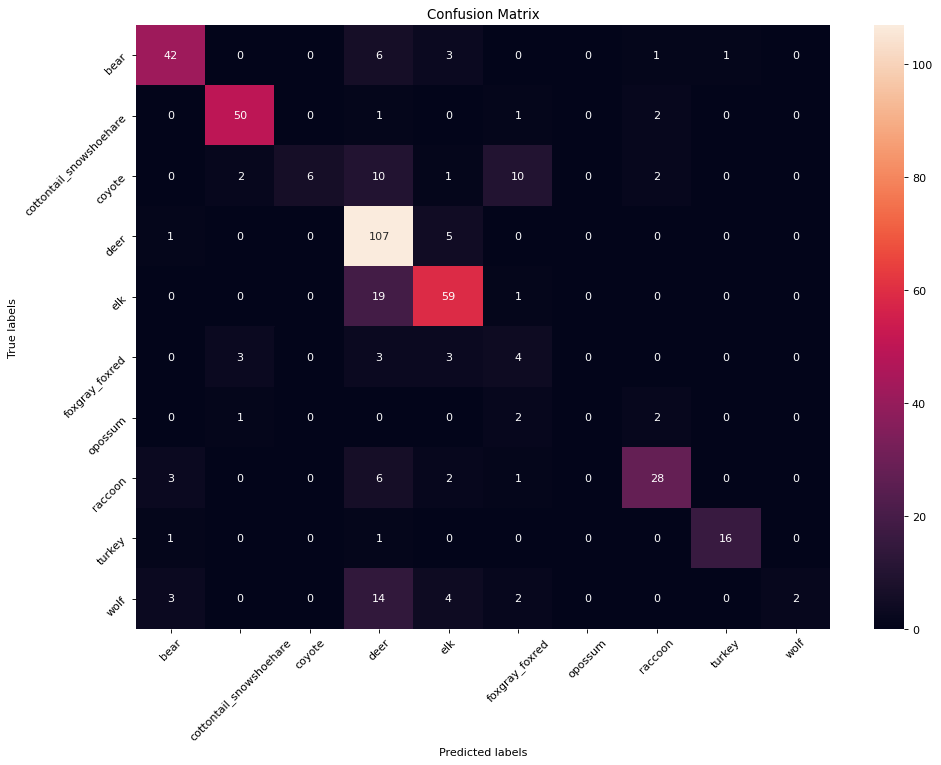

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
import pylab as pl
from matplotlib.pyplot import figure

figure(figsize=(14, 10), dpi=80)


label_list = np.unique(y_true)

cm = confusion_matrix(y_true, y_pred, labels = label_list)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel(
    'True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_list); ax.yaxis.set_ticklabels(label_list);
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

plt.show()